This notebook compares the ```depth (variance)``` and ```PSF``` of ```coadds (templates)``` and ```difference images``` from two butler collections.

The idea behind is we expect to see more variance in the good template than deep template. But, the PSF is better for the good than deep. 

1. At which point can we say using one is better over using the other?

incollection = LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648

```good seeing template :``` 
include only good seeing visits to create the template.

collection_good = f"u/jarugula/auxtel_goodseeing_template_subtract"

```deepcoadd template :```
includes all the visits to create the template. This is done by adding the following code in the pipeline yaml 

```
tasks:
    selectGoodSeeingVisits:
        class: lsst.pipe.tasks.selectImages.BestSeeingQuantileSelectVisitsTask
        config:
          connections.goodVisits: goodSeeingVisits
          qMin: 0
          qMax: 0.99
    
```
collection_deep = f"u/jarugula/auxtel_deep_template_subtract"



All the Plots and tables are in PREOPS-4952-depthcomparision.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
import random 

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.daf.butler as dafButler
from lsst.pex.config import Config
from lsst.pipe.base import Instrument
import lsst.afw.display as afwDisplay
import lsst.display.astrowidgets

afwDisplay.setDefaultBackend('astrowidgets')
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')
%matplotlib inline

### The two butler collections

In [2]:
repo = '/sdf/group/rubin/repo/embargo'
skymapName = 'latiss_v1'
instrumentName = 'LATISS'

collection_good = f"u/{os.environ['USER']}/auxtel_goodseeing_template_subtract"
collection_deep = f"u/{os.environ['USER']}/auxtel_deep_template_subtract"

butler_good = dafButler.Butler(repo, collections=collection_good, skymap=skymapName)
butler_deep = dafButler.Butler(repo, collections=collection_deep, skymap=skymapName)

registry_good = butler_good.registry
registry_deep = butler_deep.registry

### Selecting the dataids with varying number of visits going into making the good and deep templates

There are more visits in the deep than good templates.

Randomly select 10 visits from the vists going into making the coadds. We compare the variance and PSF of these visits

In [3]:
dataid_template_list = [{'band': 'r', 'skymap': 'latiss_v1', 'tract': 8188, 'patch': 65},
                        {'band': 'g', 'skymap': 'latiss_v1', 'tract': 10644, 'patch': 183},
                        {'band': 'i', 'skymap': 'latiss_v1', 'tract': 3863, 'patch': 262},
                        {'band': 'y', 'skymap': 'latiss_v1', 'tract': 383, 'patch': 359},
                        {'band': 'y', 'skymap': 'latiss_v1', 'tract': 455, 'patch': 14},
                        {'band': 'i', 'skymap': 'latiss_v1', 'tract': 5614, 'patch': 211},
                        {'band': 'i', 'skymap': 'latiss_v1', 'tract': 382, 'patch': 342},
                        {'band': 'r', 'skymap': 'latiss_v1', 'tract': 455, 'patch': 33},
                        {'band': 'g', 'skymap': 'latiss_v1', 'tract': 3864, 'patch': 254},
                        {'band': 'i', 'skymap': 'latiss_v1', 'tract': 5634, 'patch': 74},
                        {'band': 'r', 'skymap': 'latiss_v1', 'tract': 5634, 'patch': 93},
                        {'band': 'g', 'skymap': 'latiss_v1', 'tract': 3864, 'patch': 256},
                        {'band': 'g', 'skymap': 'latiss_v1', 'tract': 5634, 'patch': 92},
                        {'band': 'r', 'skymap': 'latiss_v1', 'tract': 5634, 'patch': 92}]

good_template_visits = [1, 2, 5, 4, 5, 8, 16, 22, 25, 34, 47, 63, 102, 119]
deep_template_visits = [1, 2, 5, 12, 17, 21, 41, 54, 79, 97, 137, 195, 265, 350]



In [4]:
print('Selecting random 10 visits from the visits in goodseeing template')
visit_list = []
for i, dataId in enumerate(dataid_template_list):
    # print(dataId)
    # print('Number of visits in good template: ', good_template_visits[i])
    # print('Number of visits in deep template: ', deep_template_visits[i])
    exposure_good = butler_good.get('goodSeeingCoadd', dataId=dataId)
    visits = exposure_good.getInfo().getCoaddInputs().visits["id"].tolist()
    if len(set(visits)) >= 10:
        random_visits = random.sample(visits, 10)
    else:
        random_visits = visits
    # print(random_visits)
    visit_list.append(random_visits)
    # print('----------------')

Selecting random 10 visits from the visits in goodseeing template


e.g.

![alt text](./PREOPS-4952-figures/select_visits_good_deep.png "Title")

The DIA sources from ```goodSeeingDiff_diaSrcTable``` from the selected visits

![alt text](./PREOPS-4952-figures/dia_src_example.png "Title")

In [6]:
dataId_list_all_templates = []

for i, visits in enumerate(visit_list):
    print('Number of visits in good template: ', good_template_visits[i])
    print('Number of visits in deep template: ', deep_template_visits[i])    
    refs = registry_good.queryDatasets('calexp', 
                                      where="visit IN (visit_ids)",
                                      bind={"visit_ids": visits})
    dataId_list = []
    for ref in refs:
        print(ref.dataId)
        dataId_list.append(ref.dataId)
    dataId_list_all_templates.append(dataId_list)
    print('---------------------------')

Number of visits in good template:  1
Number of visits in deep template:  1
{instrument: 'LATISS', detector: 0, visit: 2023070400574, band: 'r', day_obs: 20230704, physical_filter: 'SDSSr_65mm~empty'}
---------------------------
Number of visits in good template:  2
Number of visits in deep template:  2
{instrument: 'LATISS', detector: 0, visit: 2023070400488, band: 'g', day_obs: 20230704, physical_filter: 'SDSSg_65mm~empty'}
{instrument: 'LATISS', detector: 0, visit: 2023070400596, band: 'g', day_obs: 20230704, physical_filter: 'SDSSg_65mm~empty'}
---------------------------
Number of visits in good template:  5
Number of visits in deep template:  5
{instrument: 'LATISS', detector: 0, visit: 2023110700574, band: 'i', day_obs: 20231107, physical_filter: 'empty~SDSSi_65mm'}
{instrument: 'LATISS', detector: 0, visit: 2023110700593, band: 'i', day_obs: 20231107, physical_filter: 'empty~SDSSi_65mm'}
{instrument: 'LATISS', detector: 0, visit: 2023110700596, band: 'i', day_obs: 20231107, phy

In [7]:
visit_list_all = [x for xs in visit_list for x in xs]
num_visits_good = []
num_visits_deep = []

for i, dataId_list in enumerate(dataId_list_all_templates):
    for dataId in dataId_list:
        num_visits_good.append(good_template_visits[i])
        num_visits_deep.append(deep_template_visits[i])  

## Computing the Variance of good and deep templates and the difference images

The psf determinant radius is computed

[https://community.lsst.org/t/image-difference-task-using-decam-images-gen3/5947/27](https://community.lsst.org/t/image-difference-task-using-decam-images-gen3/5947/27)

[https://pipelines.lsst.io/py-api/lsst.afw.geom.Quadrupole.html#lsst.afw.geom.Quadrupole](https://pipelines.lsst.io/py-api/lsst.afw.geom.Quadrupole.html#lsst.afw.geom.Quadrupole)


In [8]:
# Plotting calexp, good template and difference image variance

sigma2fwhm = 2.*np.sqrt(2.*np.log(2.))

median_calexp_good = []
median_template_good = []
median_diff_good = []

psf_radius_calexp_good = []
psf_radius_template_good = []
psf_radius_diff_good = []

for i, dataId_list in enumerate(dataId_list_all_templates):
    print('Number of visits in good template: ', good_template_visits[i])

    for dataId in dataId_list:
        dataId = dataId.mapping
        dataId_string = {str(key): dataId[key] for key in dataId.keys()}
        
        calexp_image_good = butler_good.get('calexp', **dataId_string).variance
        diff_image_good = butler_good.get('goodSeeingDiff_differenceExp', **dataId_string).variance
        template_image_good = butler_good.get('goodSeeingDiff_templateExp', **dataId_string).variance

        calexp_image_psf = butler_good.get('calexp', **dataId_string).psf
        calexp_psf_radius = calexp_image_psf.computeShape(calexp_image_psf.getAveragePosition()).getDeterminantRadius()*sigma2fwhm
        
        diff_image_psf = butler_good.get('goodSeeingDiff_differenceExp', **dataId_string).psf
        diff_psf_radius = diff_image_psf.computeShape(diff_image_psf.getAveragePosition()).getDeterminantRadius()*sigma2fwhm
        
        template_image_psf = butler_good.get('goodSeeingDiff_templateExp', **dataId_string).psf
        template_psf_radius = template_image_psf.computeShape(template_image_psf.getAveragePosition()).getDeterminantRadius()*sigma2fwhm

        
        psf_radius_calexp_good.append(calexp_psf_radius)
        psf_radius_template_good.append(template_psf_radius)
        psf_radius_diff_good.append(diff_psf_radius)
    

        image_arr = template_image_good.array
        median_template = round(np.nanmedian(image_arr), 3)
        median_template_good.append(median_template)
    
        image_arr = calexp_image_good.array
        median_calexp = round(np.nanmedian(image_arr), 3)
        median_calexp_good.append(median_calexp)

        image_arr = diff_image_good.array
        median_diff = round(np.nanmedian(image_arr), 3)
        median_diff_good.append(median_diff)

        del(dataId_string)

Number of visits in good template:  1
Number of visits in good template:  2
Number of visits in good template:  5
Number of visits in good template:  4
Number of visits in good template:  5
Number of visits in good template:  8
Number of visits in good template:  16
Number of visits in good template:  22
Number of visits in good template:  25
Number of visits in good template:  34
Number of visits in good template:  47
Number of visits in good template:  63
Number of visits in good template:  102
Number of visits in good template:  119


In [9]:
# Plotting calexp, deep template and difference image variance

median_calexp_deep = []
median_template_deep = []
median_diff_deep = []

psf_radius_calexp_deep = []
psf_radius_template_deep = []
psf_radius_diff_deep = []

for i, dataId_list in enumerate(dataId_list_all_templates):
    print('Number of visits in deep template: ', deep_template_visits[i])

    for dataId in dataId_list:
        dataId = dataId.mapping
        dataId_string = {str(key): dataId[key] for key in dataId.keys()}
        calexp_image_deep = butler_deep.get('calexp', **dataId_string).variance
        diff_image_deep = butler_deep.get('goodSeeingDiff_differenceExp', **dataId_string).variance
        template_image_deep = butler_deep.get('goodSeeingDiff_templateExp', **dataId_string).variance

        calexp_image_psf = butler_deep.get('calexp', **dataId_string).psf
        calexp_psf_radius = calexp_image_psf.computeShape(calexp_image_psf.getAveragePosition()).getDeterminantRadius()*sigma2fwhm
        
        diff_image_psf = butler_deep.get('goodSeeingDiff_differenceExp', **dataId_string).psf
        diff_psf_radius = diff_image_psf.computeShape(diff_image_psf.getAveragePosition()).getDeterminantRadius()*sigma2fwhm
        
        template_image_psf = butler_deep.get('goodSeeingDiff_templateExp', **dataId_string).psf
        template_psf_radius = template_image_psf.computeShape(template_image_psf.getAveragePosition()).getDeterminantRadius()*sigma2fwhm

        psf_radius_calexp_deep.append(calexp_psf_radius)
        psf_radius_template_deep.append(template_psf_radius)
        psf_radius_diff_deep.append(diff_psf_radius)

        image_arr = template_image_deep.array
        median_template = round(np.nanmedian(image_arr), 3)
        median_template_deep.append(median_template)
    
        image_arr = calexp_image_deep.array
        median_calexp = round(np.nanmedian(image_arr), 3)
        median_calexp_deep.append(median_calexp)
    
        image_arr = diff_image_deep.array
        median_diff = round(np.nanmedian(image_arr), 3)
        median_diff_deep.append(median_diff)
    
        del(dataId_string)

Number of visits in deep template:  1
Number of visits in deep template:  2
Number of visits in deep template:  5
Number of visits in deep template:  12
Number of visits in deep template:  17
Number of visits in deep template:  21
Number of visits in deep template:  41
Number of visits in deep template:  54
Number of visits in deep template:  79
Number of visits in deep template:  97
Number of visits in deep template:  137
Number of visits in deep template:  195
Number of visits in deep template:  265
Number of visits in deep template:  350


In [ ]:
median_dict = {'num of visits in good coadd': num_visits_good,
               'num of visits in deep coadd': num_visits_deep,
               'visit' : visit_list_all,
               'median calexp variance' : median_calexp_good,
               'median template variance good' : median_template_good,
               'median template variance deep' : median_template_deep,
               'median diff variance good' : median_diff_good,
               'median diff variance deep' : median_diff_deep,
               'calexp psf' : psf_radius_calexp_deep,
               'template psf good': psf_radius_template_good,
               'template psf deep': psf_radius_template_deep,
               'diff psf good': psf_radius_diff_good,
               'diff psf deep': psf_radius_diff_deep,
              }
median_df = pd.DataFrame.from_dict(median_dict)
# median_df.to_csv('median_variance_psf_10visits_per_coadd.csv')

In [9]:
# # read the saved csv
# median_df = pd.read_csv('median_variance_psf_10visits_per_coadd.csv')
# median_template_good = median_df['median template variance good']
# median_template_deep = median_df['median template variance deep']
# median_diff_good = median_df['median diff variance good']
# median_diff_deep = median_df['median diff variance deep']
# psf_radius_calexp_deep = median_df['calexp psf']
# psf_radius_calexp_good = median_df['calexp psf']
# psf_radius_template_deep = median_df['template psf deep']
# psf_radius_template_good = median_df['template psf good']
# psf_radius_diff_good = median_df['diff psf good']
# psf_radius_diff_deep = median_df['diff psf deep']

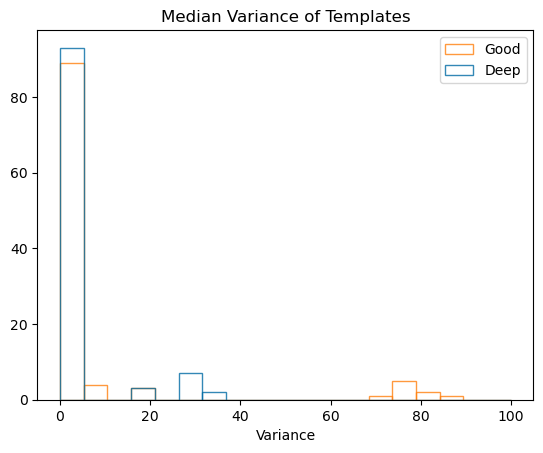

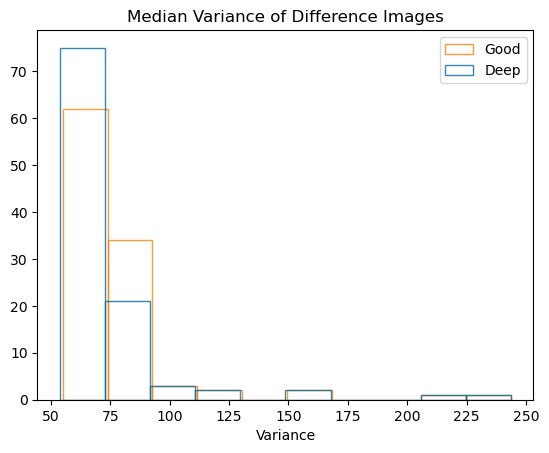

In [24]:
bins=np.linspace(0, 100, 20)
plt.hist(median_template_good, bins=bins, alpha=0.8, edgecolor='C1', label='Good', facecolor="None")
plt.hist(median_template_deep, bins=bins, alpha=0.8, edgecolor='C0', label='Deep', facecolor="None")
plt.xlabel('Variance')
plt.title('Median Variance of Templates')
plt.legend()
plt.show()
plt.close()

plt.hist(median_diff_good, alpha=0.8, edgecolor='C1', label='Good', facecolor="None")
plt.hist(median_diff_deep, alpha=0.8, edgecolor='C0', label='Deep', facecolor="None")
plt.xlabel('Variance')
plt.title('Median Variance of Difference Images')
plt.legend()
plt.show()
plt.close()


<!-- ![alt text](./PREOPS-4952-figures/median_variance_templates.png "Title") -->

<!-- ![alt text](./PREOPS-4952-figures/median_variance_diff.png "Title") -->


The variance of the good templates is slightly larger than the deep templates. 

This is expected as there are fewer visits going into making the good template than the deep template

### PSF

For the different methods of convolution refer to the notes

[https://dmtn-256.lsst.io](https://dmtn-256.lsst.io)

The default convolution algorithm adjusts the PSF of the templates (if the PSF of template is larger) to match the PSF of the calexp.

The PSF of the deep templates is larger (worse) than the good templates as expected due to more visits going into making it. 

However, the PSF of the difference images is similar no matter which template we use. This is probably because of the convolution algorithm used to match the PSFs to the PSF of calexp.

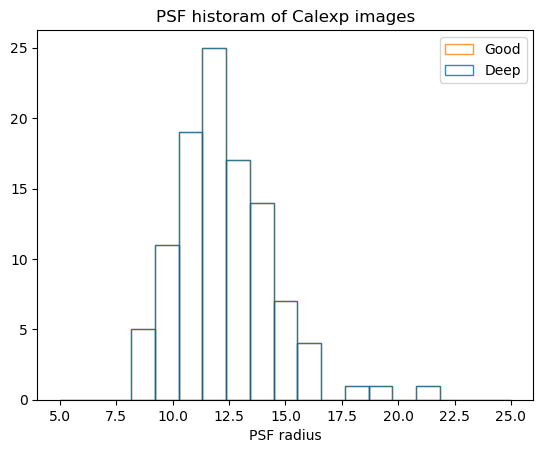

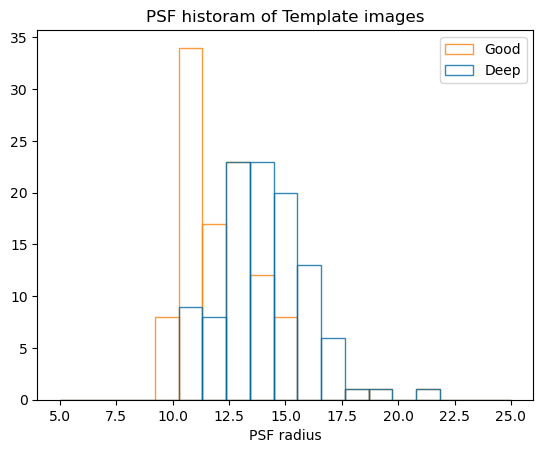

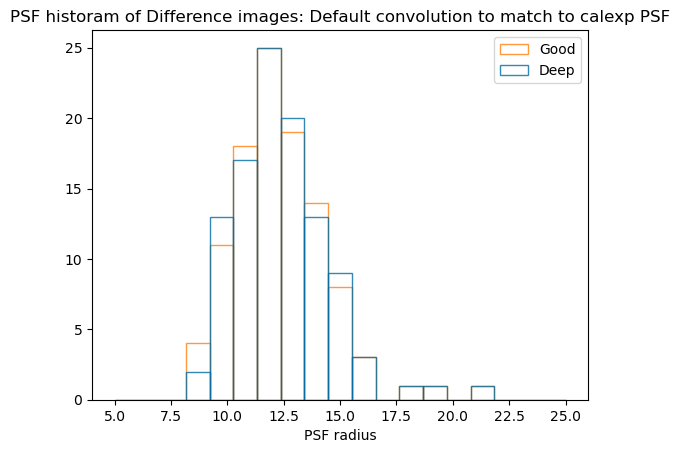

In [18]:
bins=np.linspace(5, 25, 20)
plt.hist(psf_radius_calexp_good, bins=bins, alpha=0.8, edgecolor='C1', label='Good', facecolor="None")
plt.hist(psf_radius_calexp_deep, bins=bins, alpha=0.8, edgecolor='C0', label='Deep', facecolor="None")
plt.xlabel('PSF radius')
plt.title('PSF historam of Calexp images')
plt.legend()
plt.show()
plt.close()

plt.hist(psf_radius_template_good,bins=bins,  alpha=0.8, edgecolor='C1', label='Good', facecolor="None")
plt.hist(psf_radius_template_deep, bins=bins, alpha=0.8, edgecolor='C0', label='Deep', facecolor="None")
plt.xlabel('PSF radius')
plt.title('PSF historam of Template images')
plt.legend()
plt.show()
plt.close()

plt.hist(psf_radius_diff_good, bins=bins, alpha=0.8, edgecolor='C1', label='Good', facecolor="None")
plt.hist(psf_radius_diff_deep, bins=bins, alpha=0.8, edgecolor='C0', label='Deep', facecolor="None")
plt.xlabel('PSF radius')
plt.title('PSF historam of Difference images: Default convolution to match to calexp PSF')
plt.legend()
plt.show()
plt.close()

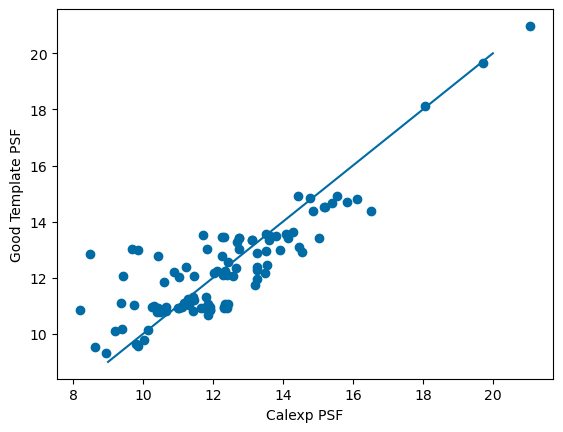

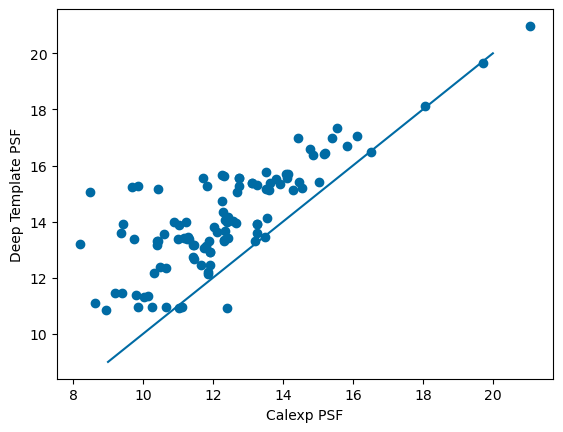

In [19]:
plt.scatter(median_df['calexp psf'], median_df['template psf good'])
plt.plot([9,20], [9, 20])
plt.xlabel('Calexp PSF')
plt.ylabel('Good Template PSF')
plt.show()
plt.close()

plt.scatter(median_df['calexp psf'], median_df['template psf deep'])
plt.plot([9,20], [9, 20])
plt.xlabel('Calexp PSF')
plt.ylabel('Deep Template PSF')
plt.show()
plt.close()

## Selecting visits where good template psf < visit psf < deep template psf 

fraction of visits with good template psf < visit psf < deep template psf :  0.524

fraction of visits with visit psf < good and deep template:  0.409

fraction of visits with deep template psf < visit psf < good template psf:  0.0

In [20]:
df_interesting_visits =  median_df[(median_df['calexp psf'] > median_df['template psf good']) 
                                    & (median_df['calexp psf'] < median_df['template psf deep'])]

# Difference between the Calexp and Template PSF
diff_visit_good = df_interesting_visits['calexp psf'].values - df_interesting_visits['template psf good'].values
diff_visit_deep =  df_interesting_visits['template psf deep'].values - df_interesting_visits['calexp psf'].values

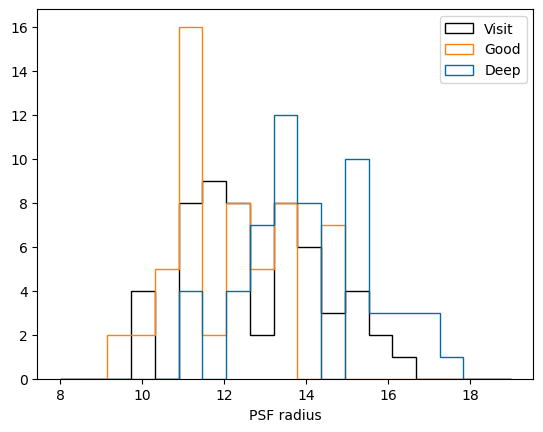

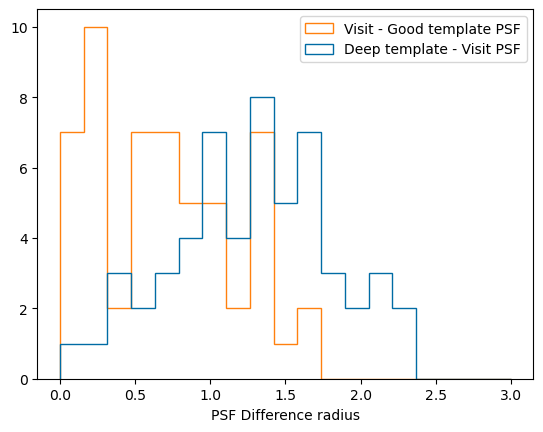

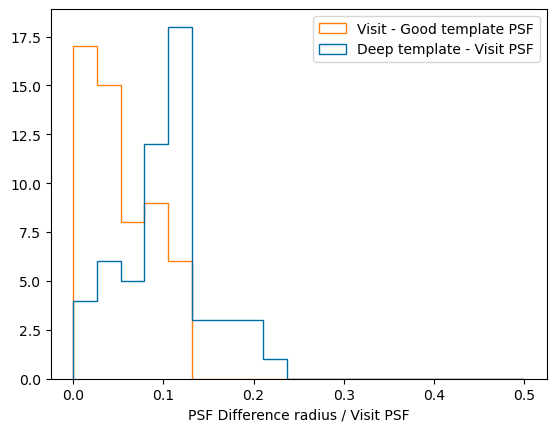

In [21]:
bins=np.linspace(8, 19, 20)
plt.hist(df_interesting_visits['calexp psf'], bins=bins, alpha=1.0, edgecolor='k',  histtype='step', label='Visit')
plt.hist(df_interesting_visits['template psf good'], bins=bins, alpha=1.0, edgecolor='C1',  histtype='step', label='Good')
plt.hist(df_interesting_visits['template psf deep'], bins=bins, alpha=1.0, edgecolor='C0',  histtype='step', label='Deep')
plt.xlabel('PSF radius')
# plt.title('PSF historam of Template images')
plt.legend()
plt.show()
plt.close()

bins=np.linspace(0.0, 3.0, 20)
plt.hist(diff_visit_good, bins=bins, alpha=1.0, edgecolor='C1',  histtype='step', label='Visit - Good template PSF')
plt.hist(diff_visit_deep, bins=bins, alpha=1.0, edgecolor='C0',  histtype='step', label='Deep template - Visit PSF')
plt.xlabel('PSF Difference radius')
# plt.title('PSF historam of Template images')
plt.legend()
plt.show()
plt.close()

bins=np.linspace(0.0, 0.5, 20)
plt.hist(diff_visit_good/df_interesting_visits['calexp psf'].values, bins=bins, alpha=1.0, edgecolor='C1',  histtype='step', label='Visit - Good template PSF')
plt.hist(diff_visit_deep/df_interesting_visits['calexp psf'].values, bins=bins, alpha=1.0, edgecolor='C0',  histtype='step', label='Deep template - Visit PSF')
plt.xlabel('PSF Difference radius / Visit PSF')
# plt.title('PSF historam of Template images')
plt.legend()
plt.show()
plt.close()

### SNR of interesting visits

Visit psf - Good psf:  1.611
Deep psf - Visit psf:  0.39


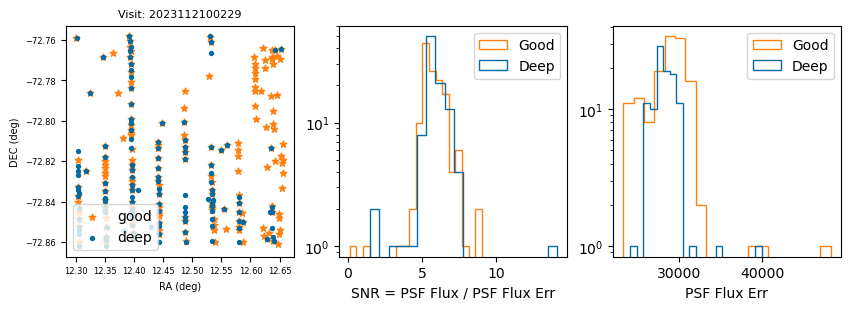

Visit psf - Good psf:  0.67
Deep psf - Visit psf:  0.845


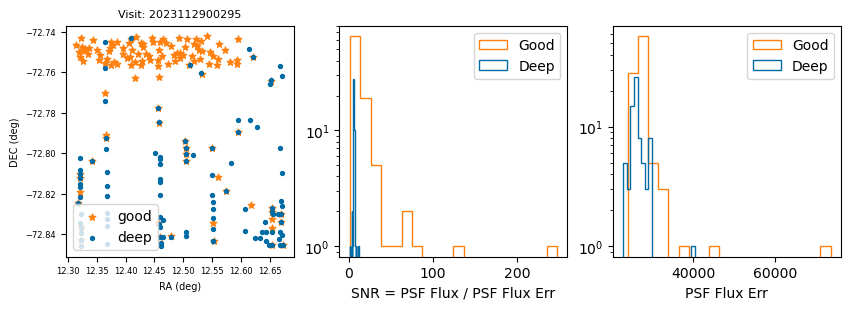

In [23]:
for visit in df_interesting_visits['visit'][0:2]:
    
    fig, axs = plt.subplots(1, 3, figsize=(10,3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .3, wspace=.2)
    axs = axs.ravel()

    DiaSourceTable_good = butler_good.get('goodSeeingDiff_diaSrcTable', visit=visit, detector=0)
    DiaSourceTable_deep = butler_deep.get('goodSeeingDiff_diaSrcTable', visit=visit, detector=0)

    axs[0].scatter(DiaSourceTable_good['ra'], DiaSourceTable_good['dec'], s=24, color='C1', label='good', marker='*')
    axs[0].scatter(DiaSourceTable_deep['ra'], DiaSourceTable_deep['dec'], s=8, color='C0', label = 'deep')
    axs[0].set_title('Visit: '+ str(visit), fontsize=8)
    axs[0].set_xlabel('RA (deg)', fontsize=7)
    axs[0].set_ylabel('DEC (deg)', fontsize=7)
    axs[0].xaxis.set_tick_params(labelsize=6)
    axs[0].yaxis.set_tick_params(labelsize=6)
    axs[0].legend(loc='lower left')

    flux_df_good = DiaSourceTable_good[['psfFlux', 'psfFluxErr']]
    flux_df_good = flux_df_good[flux_df_good['psfFlux'] > 0]
    flux_df_deep = DiaSourceTable_deep[['psfFlux', 'psfFluxErr']]
    flux_df_deep = flux_df_deep[flux_df_deep['psfFlux'] > 0]
    flux_df_good['SNR'] = flux_df_good['psfFlux']/flux_df_good['psfFluxErr']
    flux_df_deep['SNR'] = flux_df_deep['psfFlux']/flux_df_deep['psfFluxErr']

    calexp_psf = df_interesting_visits[df_interesting_visits['visit'] == visit]['calexp psf'].values
    good_psf = df_interesting_visits[df_interesting_visits['visit'] == visit]['template psf good'].values
    deep_psf = df_interesting_visits[df_interesting_visits['visit'] == visit]['template psf deep'].values
    
    diff_visit_good = calexp_psf - good_psf
    diff_visit_deep = deep_psf - calexp_psf 

    print('Visit psf - Good psf: ', round(diff_visit_good[0],3))
    print('Deep psf - Visit psf: ', round(diff_visit_deep[0],3))

    # Plot SNR
    
    bins = 20

    axs[1].hist(flux_df_good['SNR'],bins=bins, histtype = 'step', alpha=1.0, edgecolor='C1', label='Good');
    axs[1].hist(flux_df_deep['SNR'],bins=bins, histtype = 'step', alpha=1.0, edgecolor='C0',label='Deep');
    
    axs[1].set_xlabel('SNR = PSF Flux / PSF Flux Err')
    axs[1].set_yscale('log')
    axs[1].legend(loc='upper right')

    # Plot psf flux error

    axs[2].hist(flux_df_good['psfFluxErr'],bins=bins, histtype = 'step', alpha=1.0, edgecolor='C1', label='Good');
    axs[2].hist(flux_df_deep['psfFluxErr'],bins=bins, histtype = 'step', alpha=1.0, edgecolor='C0',label='Deep');
    
    axs[2].set_xlabel('PSF Flux Err')
    axs[2].set_yscale('log')
    axs[2].legend(loc='upper right')

    
    plt.show()
    plt.close()